In [298]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import GPy

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

In [299]:
data = pd.read_csv('data\data_gp_pm25_10s.csv')
iaq_type = 'PM2.5'

# data =pd.read_csv('data\data_gp_voc_10s.csv')
# iaq_type = 'TVOC'

In [300]:
train_horizon = 300
predict_horizon = 600
interval = 5

In [301]:
# Convert the data to a NumPy array
data_array = np.array(data)

# Extract the first three columns
xy = data_array[:, 1:3]
xyt = np.hstack((xy, interval*np.arange(len(data)).reshape(-1, 1)))
Y = data_array[:, 3]

In [302]:
# Splitting the data into training and testing sets
xyt_train, xyt_test, Y_train, Y_test, = train_test_split(xyt, Y, test_size=0.2, random_state=42)

In [303]:
scaler = StandardScaler().fit(xyt_train)
xyt_scaled = scaler.transform(xyt_train)
xyt_test_scaled = scaler.transform(xyt_test)

In [304]:
def gp_train(xyt, Y):
    # kernel = ConstantKernel() * RBF() + WhiteKernel()
    # model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
    # model.fit(xyt, Y)
    # spatial_kernel = GPy.kern.RBF(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=True, variance=1.0)
    spatial_kernel = GPy.kern.Matern32(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=True, variance=1.0)
    # # tvoc temporal kernel
    # temporal_kernel = GPy.kern.StdPeriodic(input_dim=1, active_dims=[2], period=4, lengthscale=1.0, variance=1.0)
    # # pm10 temporal kernel
    # temporal_kernel = GPy.kern.RBF(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0)
    # temporal_kernel = GPy.kern.Matern32(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0)
    # temporal_kernel = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[2], lengthscale=1.0, period=1.0, variance=1.0)
    temporal_kernel = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0, period=6.283185307179586, n_freq=100, lower=0.0, upper=12.566370614359172)
    # temporal_kernel = GPy.kern.StdPeriodic(input_dim=1, active_dims=[2], period=4.0, lengthscale=1.0, variance=1.0)
    # temporal_kernel = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[2], lengthscale=1.0, period=1.0, variance=1.0)
    # temporal_kernel = GPy.kern.Cosine(input_dim=1, active_dims=[2], lengthscale=1e3, variance=1e-5)
    kernel = spatial_kernel * temporal_kernel

    # Instantiate the Gaussian process regression model
    gpr = GPy.models.GPRegression(xyt, Y.reshape(-1,1), kernel=kernel)

    # Fit the model to the training data
    gpr.optimize(messages=True)
    return gpr

In [305]:
# Define the kernel for the Gaussian process
spatial_kernel = GPy.kern.RBF(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=False, variance=1.0)
# tvoc temporal kernel
# temporal_kernel = GPy.kern.StdPeriodic(input_dim=1, active_dims=[2], period=4.0, lengthscale=1.0, variance=1.0)
temporal_kernel = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0, period=6.283185307179586, n_freq=100, lower=0.0, upper=12.566370614359172)
# pm10 temporal kernel
# temporal_kernel = GPy.kern.RBF(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0)
# temporal_kernel = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[2], lengthscale=1.0, period=1.0, variance=1.0)
# temporal_kernel = GPy.kern.Cosine(input_dim=1, active_dims=[2], lengthscale=1e3, variance=1e-5)
kernel = spatial_kernel * temporal_kernel

# Instantiate the Gaussian process regression model
gpr = GPy.models.GPRegression(xyt_scaled, Y_train.reshape(-1,1), kernel=kernel)

# Fit the model to the training data
gpr.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s24  0017   9.183147e+02   4.389911e+01 
    03s35  0026   9.581314e+02   9.226499e+03 
    06s50  0051   8.840909e+02   1.035854e-03 
    06s80  0054   8.840909e+02   5.447258e-09 
Runtime:     06s80
Optimization status: Converged



In [306]:
y_pred, y_var = gpr.predict(xyt_test_scaled)

In [307]:
y_pred = y_pred.flatten()
y_var = y_var.flatten()

In [308]:
# Compute the 95% confidence interval
y_std = np.sqrt(y_var)
y_upper = y_pred + 1.96 * y_std
y_lower = y_pred - 1.96 * y_std

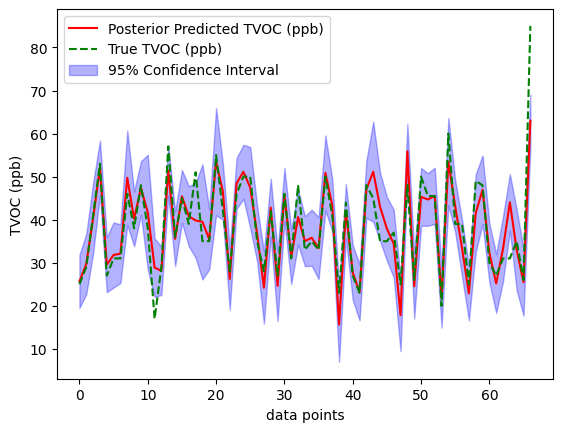

In [309]:
plt.plot(np.arange(len(y_pred)), y_pred, label='Posterior Predicted TVOC (ppb)', color='r')
plt.plot(np.arange(len(y_pred)), Y_test, label='True TVOC (ppb)', color='g', linestyle='--')
# plt.scatter(np.arange(len(y_pred)), Y_test, label='True TVOC (ppb)', color='g', marker='x')
# plt.scatter(np.arange(len(y_pred)), y_pred, label='Posterior Predicted TVOC (ppb)', color='r',marker='x')
plt.fill_between(np.arange(len(y_pred)), y_lower, y_upper, alpha=0.3, color='b', label='95% Confidence Interval')
# Scatter plot with error bars
# plt.errorbar(np.arange(len(y_pred)), y_pred, yerr=1.96*y_std, fmt='o', color='r', ecolor='k', capsize=3, capthick=1)

plt.xlabel('data points')
plt.ylabel('TVOC (ppb)')
plt.legend()

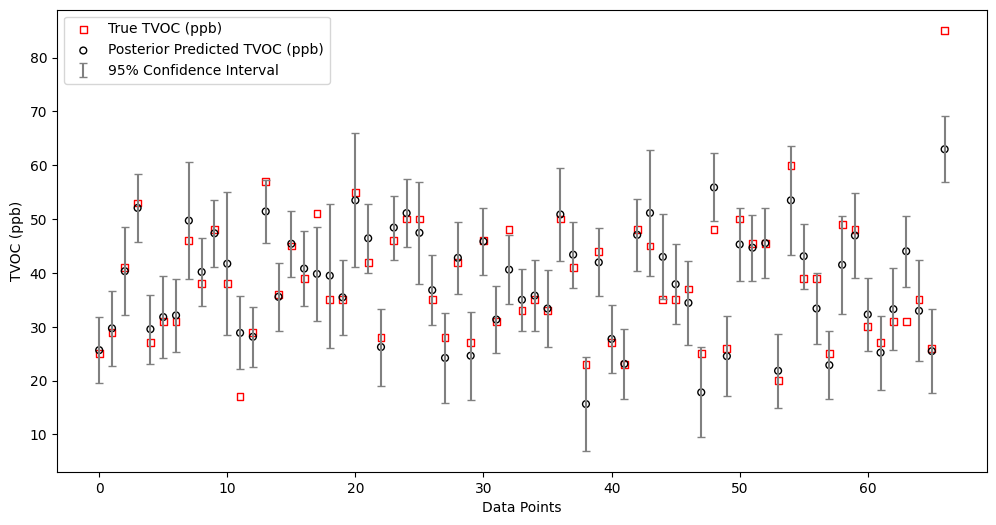

In [310]:
plt.figure(figsize=(12, 6))
# True values as smaller squares with only borders (hollow squares)
plt.scatter(np.arange(len(Y_test)), Y_test, label='True TVOC (ppb)', edgecolor='red', facecolor='none', marker='s', s=24)

# Predicted values as smaller circles with only borders (hollow circles)
plt.scatter(np.arange(len(y_pred)), y_pred, label='Posterior Predicted TVOC (ppb)', edgecolor='black', facecolor='none', marker='o', s=24)

# Error bars to represent confidence interval
plt.errorbar(np.arange(len(y_pred)), y_pred, yerr=1.96*y_std, fmt='none', ecolor='gray', capsize=3, label='95% Confidence Interval')

plt.xlabel('Data Points')
plt.ylabel('TVOC (ppb)')
plt.legend()
plt.show()

In [311]:
def evaluate(y_true, y_pred, print_metrics=False):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    nmse = mean_squared_error(y_true, y_pred) / (np.mean(y_true) * np.mean(y_pred))
    correlation = np.corrcoef(np.asarray(y_true, dtype=float), np.asarray(y_pred, dtype=float))[0, 1]
    if print_metrics:
        print('Correlation: {:.2f}'.format(correlation))
        print('NMSE: {:.2f}'.format(nmse))
        print('RMSE: {:.2f}'.format(rmse))
        print('MAE: {:.2f}'.format(mae))
        print('R2: {:.2f}'.format(r2))
    return correlation, nmse, rmse, mae, r2

In [312]:
def factioanl_error(y_true, y_pred, print_metrics=False):
    fb = 2 * (np.mean(y_pred) - np.mean(y_true)) / (np.mean(y_true) + np.mean(y_pred))
    fs = 2 * (np.var(y_pred) - np.var(y_true)) / (np.var(y_true) + np.var(y_pred))
    if print_metrics:
        print('Fractional Bias: {:.2f}'.format(fb))
        print('Fractional Spread: {:.2f}'.format(fs))
    return fb, fs

In [313]:
def regression_line(y_pred, y_true):
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)
    model = LinearRegression().fit(y_pred, y_true)
    slope = model.coef_[0]
    intercept = model.intercept_
    intercept_ratio = intercept / np.mean(y_true)
    return slope, intercept_ratio

In [314]:
def plot_regression_line(y_pred, y_true, model_name = 'GPR', iaq = 'TVOC'):
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)
    model = LinearRegression().fit(y_pred, y_true)
    intercept = model.intercept_

    plt.figure()
    plt.scatter(y_pred, y_true, color='blue')

    y_pred_line = np.linspace(np.min(y_pred), np.max(y_pred), len(y_pred), dtype='float64')
    y_rol = model.predict(y_pred_line.reshape(-1, 1))
    # Plot the slope 1.25 and slope 0.75 lines
    plt.plot(y_pred_line, y_rol, color='red', linewidth=2)
    plt.plot(y_pred_line, 1.25*y_pred_line + (y_rol[0] - 1.25*y_pred_line[0]), color='green', linestyle='-', zorder=1)
    plt.plot(y_pred_line, 0.75*y_pred_line + (y_rol[0] - 0.75*y_pred_line[0]), color='green', linestyle='-', zorder=1)

    plt.fill_between(y_pred_line, 
                     0.75*y_pred_line + (y_rol[0] - 0.75*y_pred_line[0]), 
                     1.25*y_pred_line + (y_rol[0] - 1.25*y_pred_line[0]), color='green', alpha=0.2, label='Accepatble Slope Range')

    plt.axhline(y=intercept, color='orange', linestyle='--', label='Intercept Line')
    plt.axhspan(ymin=-0.25*np.mean(y_true), ymax=0.25*np.mean(y_true), color='magenta', alpha=0.3, label='25% Mean of Measurements')
    
    if iaq == 'TVOC':
        plt.xlabel('Predicted TVOC (ppb)')
        plt.ylabel('True TVOC (ppb)')
        plt.title(f'{model_name} TVOC Regression Line')
    elif iaq == 'PM2.5':
        plt.xlabel('Predicted PM2.5 (ug/m3)')
        plt.ylabel('True PM2.5 (ug/m3)')
        plt.title(f'{model_name} PM2.5 Regression Line')
    plt.legend()
    # plt.margins(0)  # Reduce margins
    plt.tight_layout()

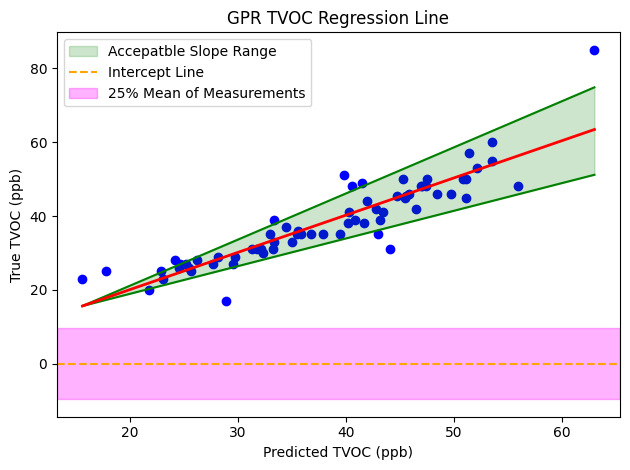

In [315]:
plot_regression_line(y_pred, Y_test)

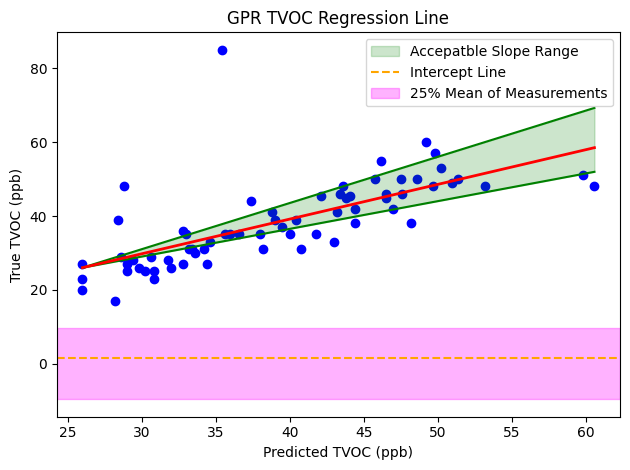

In [316]:
# Initialize the KNN model
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
knn.fit(xyt_scaled, Y_train)

# Make predictions on the test set
knn_predictions = knn.predict(xyt_test_scaled)

evaluate(Y_test, knn_predictions)
plot_regression_line(knn_predictions, Y_test)

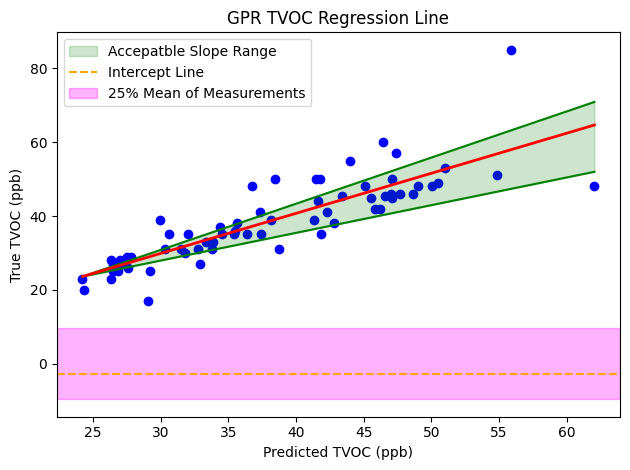

In [317]:
# Initialize the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(xyt_scaled, Y_train)

# Make predictions on the test set
rf_predictions = rf.predict(xyt_test_scaled)

evaluate(Y_test, rf_predictions)
plot_regression_line(rf_predictions, Y_test)

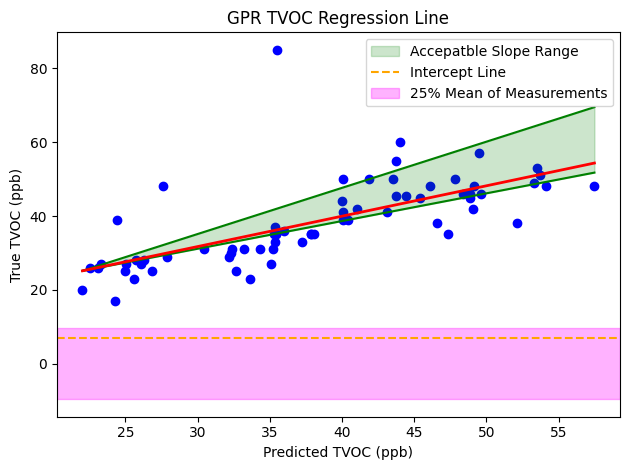

In [318]:
# Initialize the SVM model
svm = SVR(kernel='rbf', C=100.0, epsilon=0.1)

# Fit the model on the training data
svm.fit(xyt_scaled, Y_train)

# Make predictions on the test set
svm_predictions = svm.predict(xyt_test_scaled)

# Evaluate the SVM model
evaluate(Y_test, svm_predictions)
plot_regression_line(svm_predictions, Y_test)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0001   5.628437e+04   1.701074e+09 
    02s37  0019   1.039456e+03   6.521176e+04 
    04s61  0037   9.199936e+02   1.239679e+00 
    07s70  0061   9.198887e+02   6.744149e+00 
    08s12  0065   9.198805e+02   8.835017e-06 
Runtime:     08s12
Optimization status: Converged

Fractional Bias: -0.02
Fractional Spread: -0.22
Fractional Bias: 0.01
Fractional Spread: -0.44
Fractional Bias: 0.01
Fractional Spread: -0.36
Fractional Bias: -0.02
Fractional Spread: -0.43
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0001   5.225720e+04   1.447547e+09 
    01s33  0013   1.186545e+03   1.537894e+04 
Runtime:     01s33
Optimization status: Converged

Fractional Bias: -0.03
Fractional Spread: -0.45
Fractional Bias: 0.01
Fractional Spread: -0.56
Fractional Bias: -0.00
Fractional Spread: -0.49
Fractional Bias: -0.03
Fractional Spread: -0.56
Runn

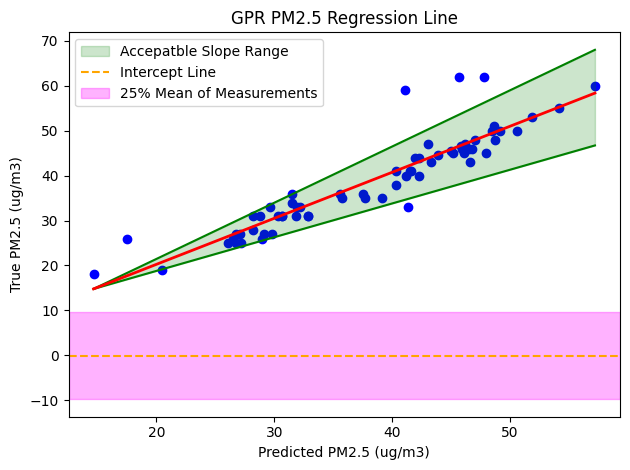

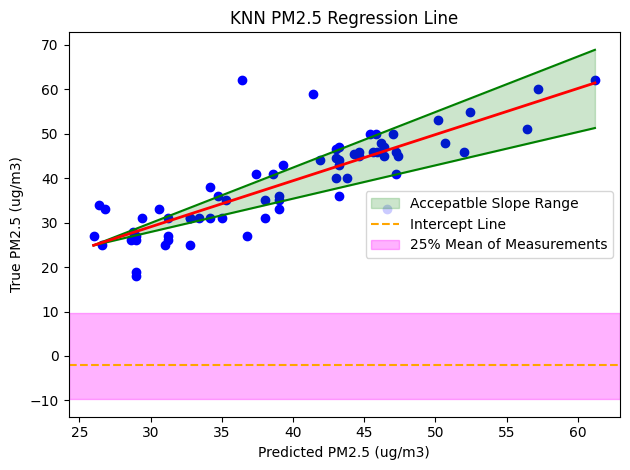

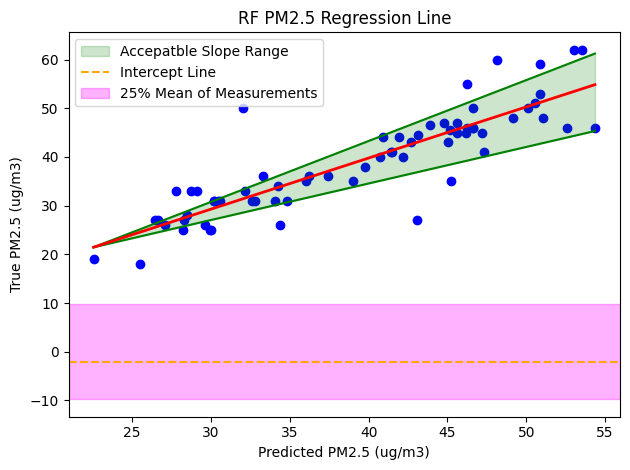

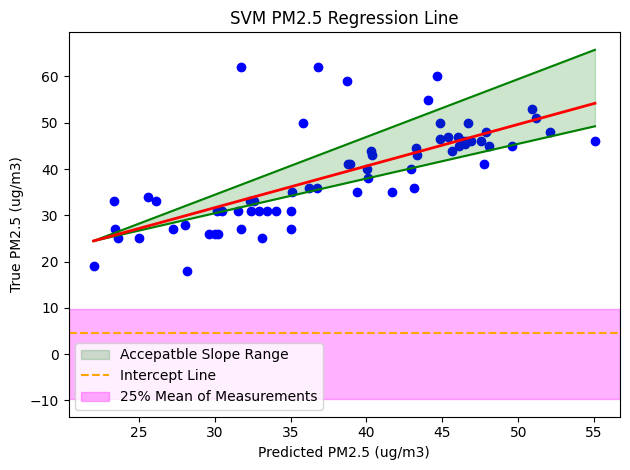

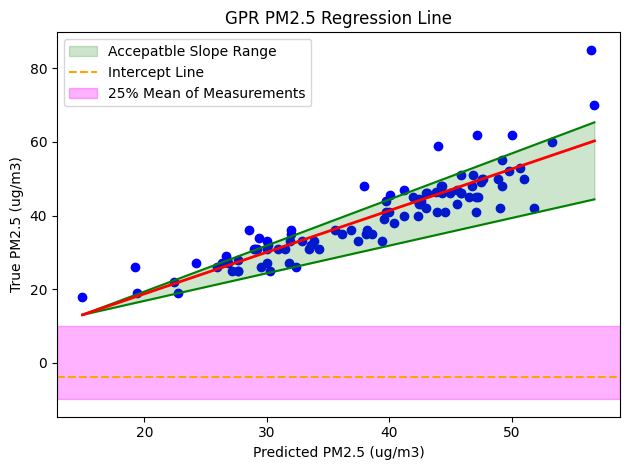

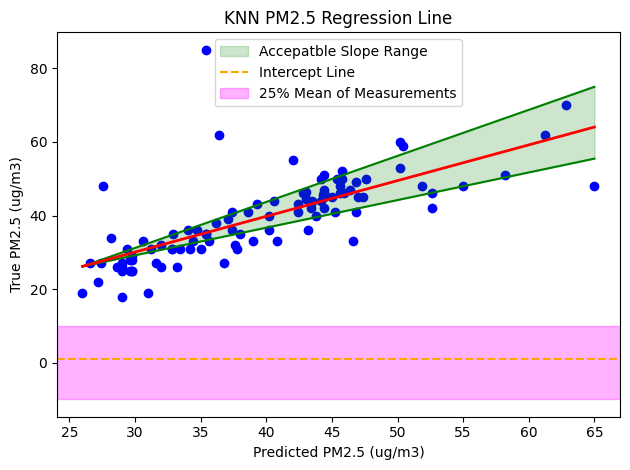

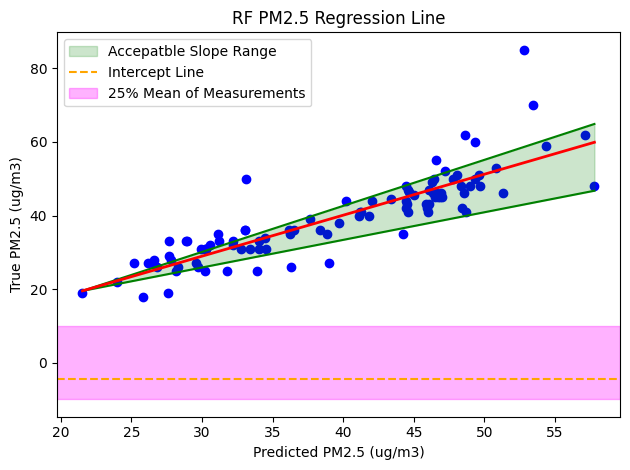

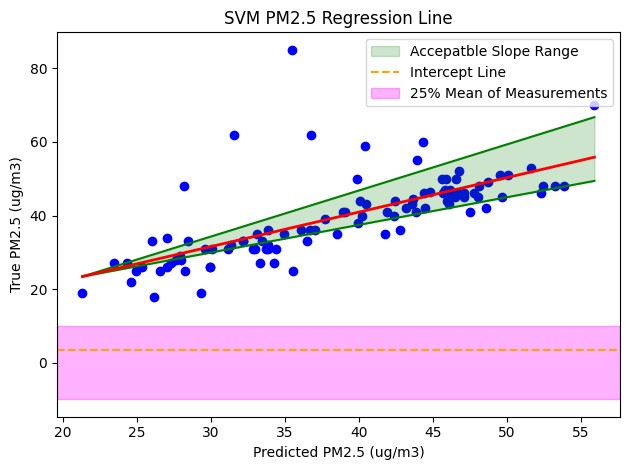

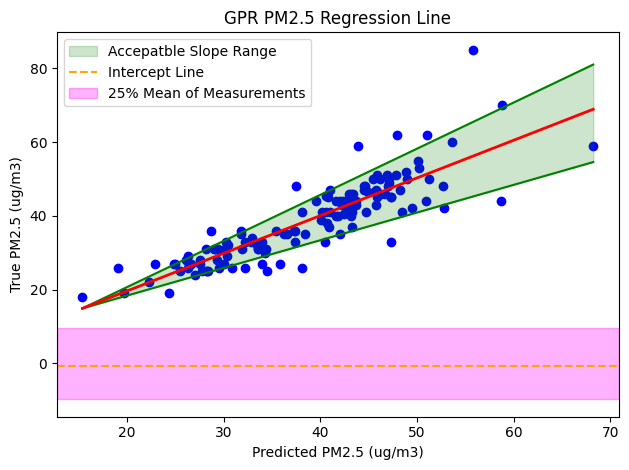

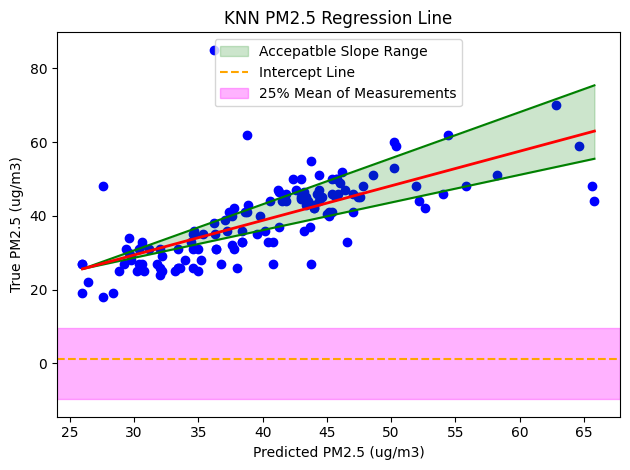

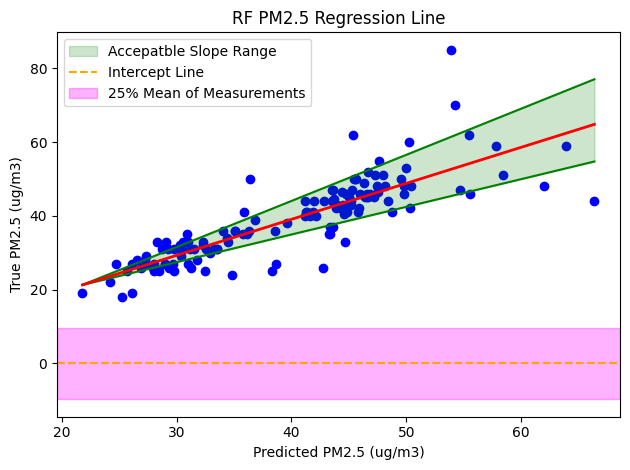

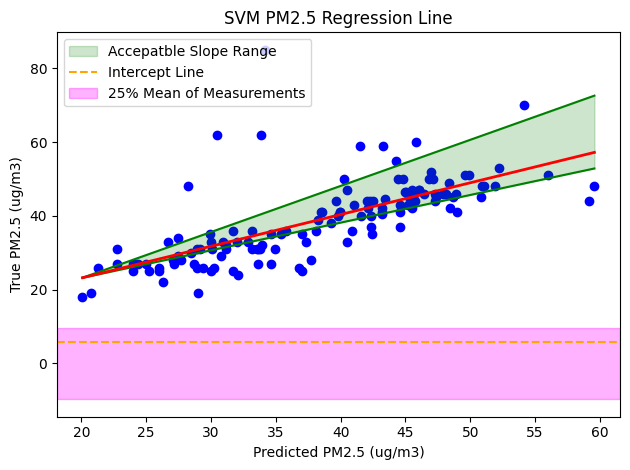

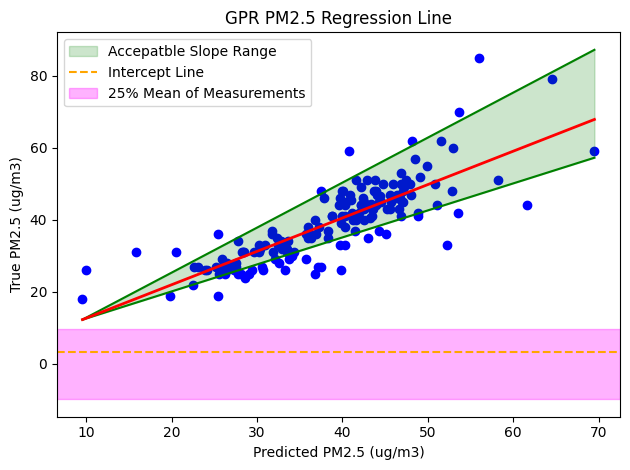

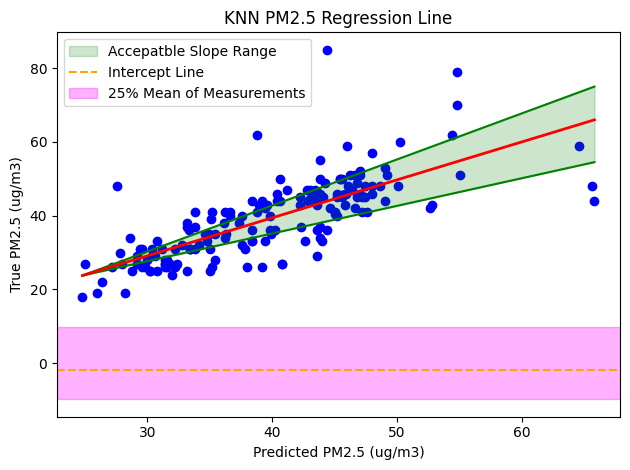

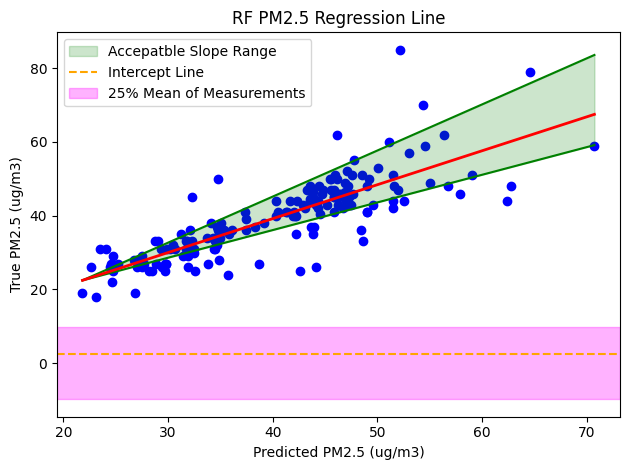

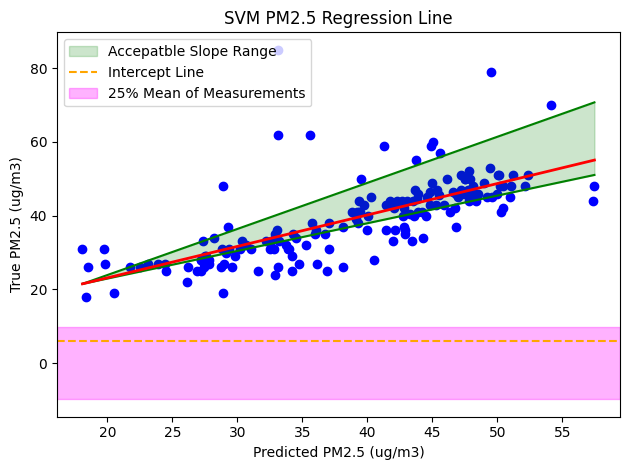

In [319]:
reduction = [0.2, 0.3, 0.4, 0.5]
models = ['GPR', 'KNN', 'RF', 'SVM']

correlations = np.zeros((len(reduction),4))
nmses = np.zeros((len(reduction),4))
rmses = np.zeros((len(reduction),4))
maes = np.zeros((len(reduction),4))
r2s = np.zeros((len(reduction),4))
fbs = np.zeros((len(reduction),4))
fss = np.zeros((len(reduction),4))
# cv_rmses = np.zeros((len(reduction),4))

for i, r in enumerate(reduction):
    xyt_train, xyt_test, Y_train, Y_test, = train_test_split(xyt, Y, test_size=r, random_state=3470)
    scaler = StandardScaler().fit(xyt_train)
    xyt_scaled = scaler.transform(xyt_train)
    xyt_test_scaled = scaler.transform(xyt_test)

    gpr = gp_train(xyt_scaled, Y_train)
    y_pred, y_var = gpr.predict(xyt_test_scaled)
    
    plot_regression_line(y_pred, Y_test, iaq=iaq_type)
    plt.savefig(f'figure/random_{iaq_type}_reduction_{r}_{models[0]}.png')
    correlations[i,0], nmses[i,0], rmses[i,0], maes[i,0], r2s[i,0]= evaluate(Y_test.flatten(), y_pred.flatten())
    fbs[i,0], fss[i,0] = factioanl_error(Y_test.flatten(), y_pred.flatten(), print_metrics=True)

    # Initialize the KNN model
    knn = KNeighborsRegressor(n_neighbors=5)
    # Fit the model on the training data
    knn.fit(xyt_scaled, Y_train)
    # Make predictions on the test set
    knn_predictions = knn.predict(xyt_test_scaled)

    plot_regression_line(knn_predictions, Y_test, model_name=models[1], iaq=iaq_type)
    plt.savefig(f'figure/random_{iaq_type}_reduction_{r}_{models[1]}.png')
    correlations[i,1], nmses[i,1], rmses[i,1], maes[i,1], r2s[i,1] = evaluate(Y_test, knn_predictions)
    fbs[i,1], fss[i,1] = factioanl_error(Y_test.flatten(), knn_predictions.flatten(), print_metrics=True)

    # Initialize the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    # Fit the model on the training data
    rf.fit(xyt_scaled, Y_train)
    # Make predictions on the test set
    rf_predictions = rf.predict(xyt_test_scaled)

    plot_regression_line(rf_predictions, Y_test, model_name=models[2],  iaq=iaq_type)
    plt.savefig(f'figure/random_{iaq_type}_reduction_{r}_{models[2]}.png')
    correlations[i,2], nmses[i,2], rmses[i,2], maes[i,2], r2s[i,2] = evaluate(Y_test, rf_predictions)
    fbs[i,2], fss[i,2] = factioanl_error(Y_test.flatten(), rf_predictions.flatten(), print_metrics=True)
    
    # Initialize the SVM model
    svr = SVR(kernel='rbf', C=100.0, epsilon=0.1)
    # Fit the model on the training data
    svr.fit(xyt_scaled, Y_train)
    # Make predictions on the test set
    svr_predictions = svr.predict(xyt_test_scaled) 
    plt.savefig(f'figure/random_{iaq_type}_reduction_{r}_{models[3]}.png')
    plot_regression_line(svr_predictions, Y_test, model_name=models[3], iaq=iaq_type)
    correlations[i,3], nmses[i,3], rmses[i,3], maes[i,3], r2s[i,3] = evaluate(Y_test, svr_predictions)
    fbs[i,3], fss[i,3] = factioanl_error(Y_test.flatten(), svr_predictions.flatten(), print_metrics=True)

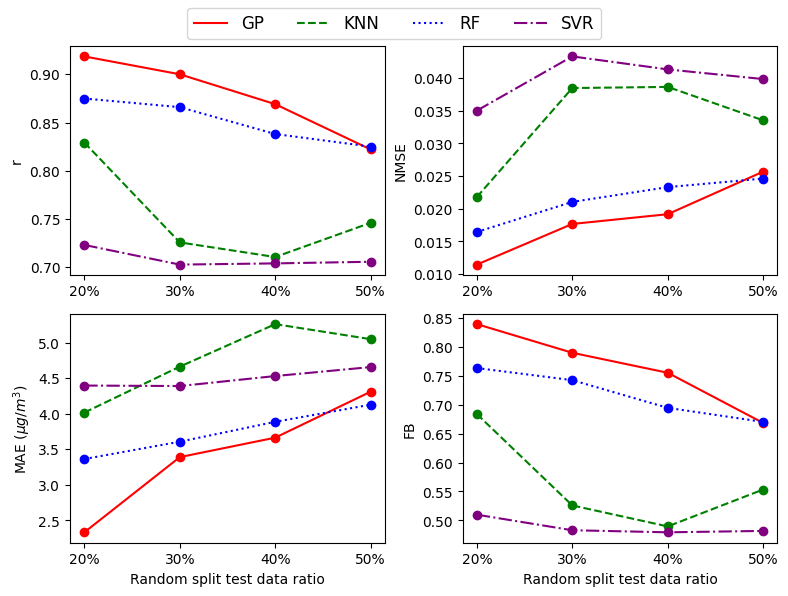

In [320]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))  # Create a 2x2 grid of subplots

# Titles for clarity
if iaq_type == 'TVOC':
    titles = ['r', 'NMSE', 'MAE (ppb)', 'r$^2$','FB']
elif iaq_type == 'PM2.5':
    titles = ['r', 'NMSE', 'MAE ($\mu g/m^3$)','FB']
data = [correlations, nmses, maes, r2s, fbs, fss]
labels = ['GP', 'KNN', 'RF', 'SVR']
colors = ['red', 'green', 'blue', 'purple']  # Colors for each model
line_styles = ['-', '--', ':', '-.']  # Different line styles for each model

# Iterate over the range of metrics and plot each in its subplot
for i in range(4):
    ax = axs[i//2, i%2]  # Determine the position of the current subplot
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['20%', '30%', '40%', '50%'])
    for j in range(4):
        ax.plot(data[i][:, j], label=labels[j], color=colors[j], linestyle=line_styles[j], marker='o')
    if i//2 == 0:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Random split test data ratio')
    ax.set_ylabel(titles[i])
    # ax.grid(True)  # Optional: Add grid for better readability

# Create a single legend for all subplots
lines = [plt.Line2D([0], [0], color=color, linestyle=style) for color, style in zip(colors, line_styles)]
fig.legend(lines, labels, loc='upper center', ncol=4, frameon=True, fontsize='large')

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend above
plt.savefig(f'figure/random_{iaq_type}_metrics.png')


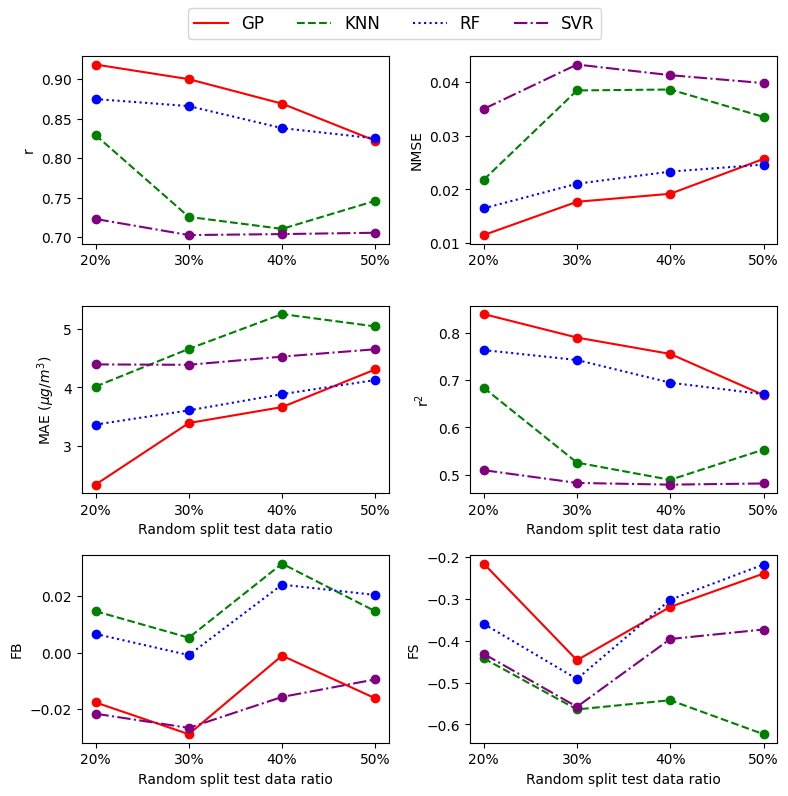

In [321]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # Create a 2x2 grid of subplots

# Titles for clarity
if iaq_type == 'TVOC':
    titles = ['r', 'NMSE', 'MAE (ppb)', 'r$^2$','FB', 'FS']
elif iaq_type == 'PM2.5':
    titles = ['r', 'NMSE', 'MAE ($\mu g/m^3$)', 'r$^2$','FB', 'FS']
data = [correlations, nmses, maes, r2s, fbs, fss]
labels = ['GP', 'KNN', 'RF', 'SVR']
colors = ['red', 'green', 'blue', 'purple']  # Colors for each model
line_styles = ['-', '--', ':', '-.']  # Different line styles for each model

# Iterate over the range of metrics and plot each in its subplot
for i in range(6):
    ax = axs[i//2, i%2]  # Determine the position of the current subplot
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['20%', '30%', '40%', '50%'])
    for j in range(4):
        ax.plot(data[i][:, j], label=labels[j], color=colors[j], linestyle=line_styles[j], marker='o')
    if i//2 == 0:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Random split test data ratio')
    ax.set_ylabel(titles[i])
    # ax.grid(True)  # Optional: Add grid for better readability

# Create a single legend for all subplots
lines = [plt.Line2D([0], [0], color=color, linestyle=style) for color, style in zip(colors, line_styles)]
fig.legend(lines, labels, loc='upper center', ncol=4, frameon=True, fontsize='large')

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend above
plt.savefig(f'figure/random_{iaq_type}_metrics_extended.png')


In [322]:
# Create a DataFrame to hold the metrics for all four model types
metrics_df = pd.DataFrame({
    'Reduction': ['20%', '30%', '40%', '50%'],
    'GPR_Correlation': correlations[:, 0],
    'GPR_NMSE': nmses[:, 0],
    'GPR_MAE': maes[:, 0],
    'GPR_FB': fbs[:, 0],
    'GPR_FS': fss[:, 0],
    'GPR_R2': r2s[:, 0],
    'KNN_Correlation': correlations[:, 1],
    'KNN_NMSE': nmses[:, 1],
    'KNN_MAE': maes[:, 1],
    'KNN_FB': fbs[:, 1],
    'KNN_FS': fss[:, 1],
    'KNN_R2': r2s[:, 1],
    'RF_Correlation': correlations[:, 2],
    'RF_NMSE': nmses[:, 2],
    'RF_MAE': maes[:, 2],
    'RF_FB': fbs[:, 2],
    'RF_FS': fss[:, 2],
    'RF_R2': r2s[:, 2],
    'SVM_Correlation': correlations[:, 3],
    'SVM_NMSE': nmses[:, 3],
    'SVM_MAE': maes[:, 3],
    'SVM_FB': fbs[:, 3],
    'SVM_FS': fss[:, 3],
    'SVM_R2': r2s[:, 3]
})

# Print the DataFrame in a tabulated format
print(metrics_df)
metrics_df.to_csv(f'figure/random_{iaq_type}_metrics.csv', index=False)

  Reduction  GPR_Correlation  GPR_NMSE   GPR_MAE    GPR_FB    GPR_FS  \
0       20%         0.918527  0.011466  2.331874 -0.017663 -0.215870   
1       30%         0.900016  0.017678  3.388803 -0.028929 -0.446404   
2       40%         0.869037  0.019172  3.662331 -0.001087 -0.319147   
3       50%         0.822107  0.025676  4.308783 -0.016230 -0.239670   

     GPR_R2  KNN_Correlation  KNN_NMSE   KNN_MAE  ...    RF_MAE     RF_FB  \
0  0.838857         0.829302  0.021790  4.014925  ...  3.362015  0.006608   
1  0.789425         0.725810  0.038459  4.661000  ...  3.605800 -0.000889   
2  0.754898         0.710647  0.038634  5.258209  ...  3.885075  0.024088   
3  0.668303         0.746150  0.033519  5.046707  ...  4.126108  0.020425   

      RF_FS     RF_R2  SVM_Correlation  SVM_NMSE   SVM_MAE    SVM_FB  \
0 -0.359620  0.763088         0.723172  0.035005  4.394810 -0.021665   
1 -0.491310  0.742139         0.702811  0.043296  4.388016 -0.026697   
2 -0.302029  0.694380         0.70405